
Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area
Fold 1 accuracy: 1.000 | balanced accuracy: 1.000
  True: [0 2 1] | Pred: [0 2 1]
Fold 2 

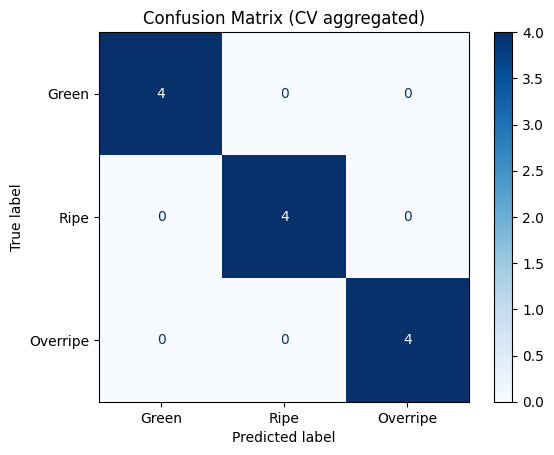

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_3104\1756222058.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top), palette='coolwarm')


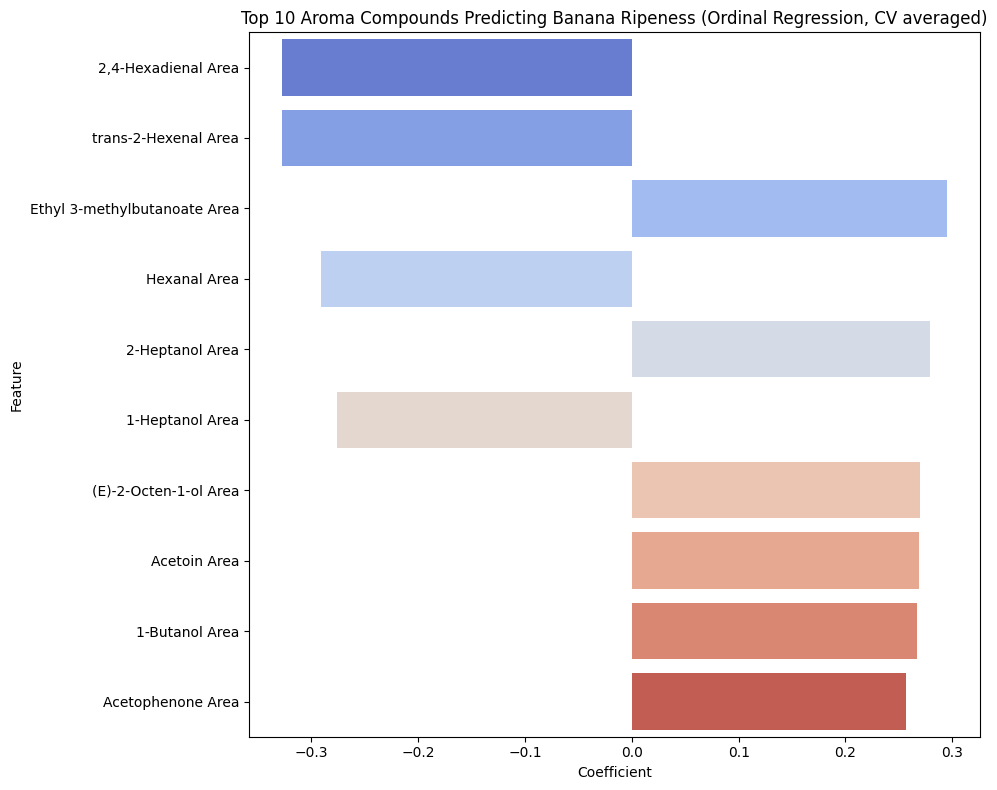

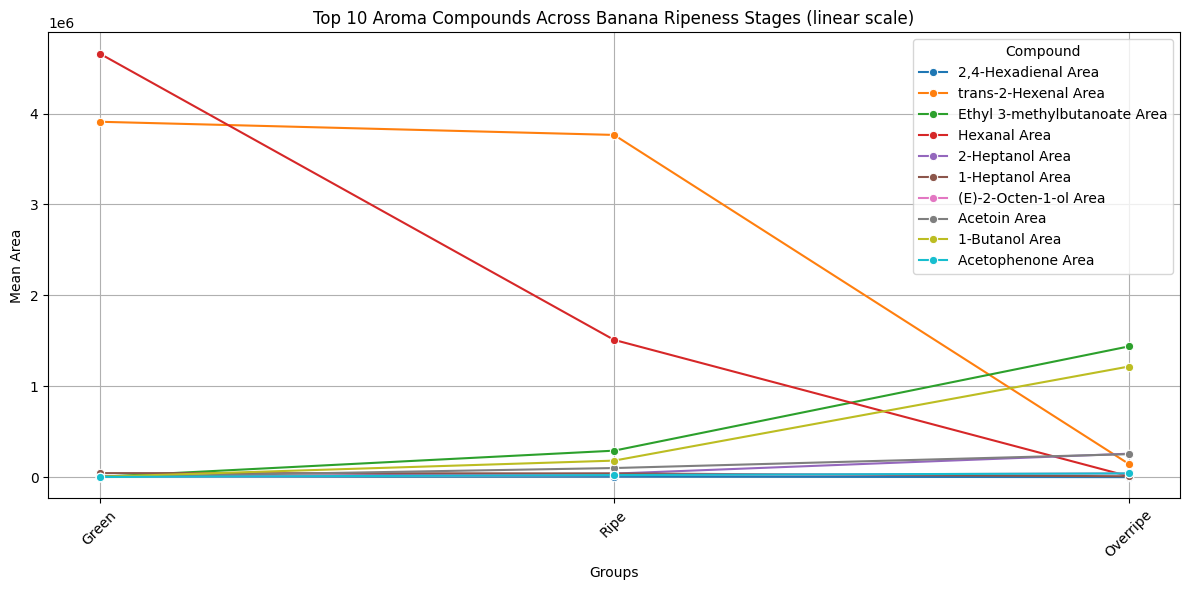

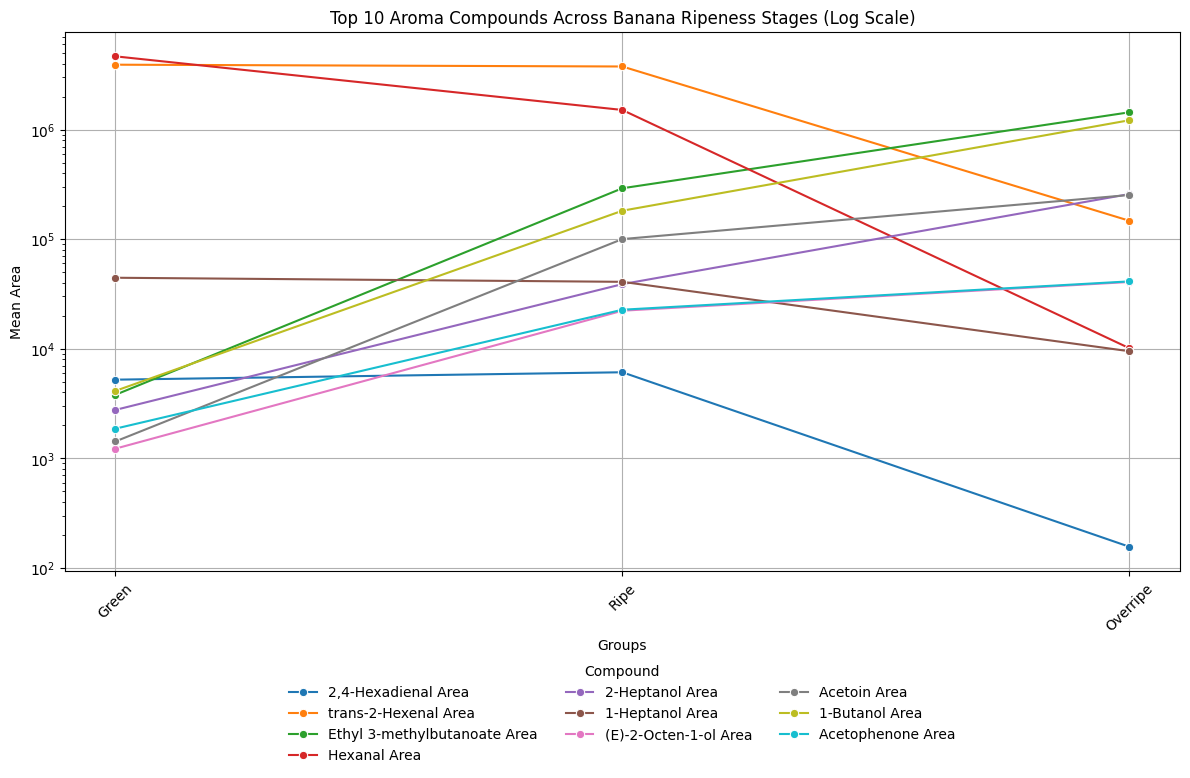

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from mord import LogisticAT  # Ordinal regression model
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# parameter: this can be adjusted to show the number of top values to display in figures
top = 10

# ---------------------------------------------------
# Load dataset
# ---------------------------------------------------
df = pd.read_csv('badata_imputed.csv')

# Drop the first unnamed column as it's an index
df = df.drop(columns=[df.columns[0]])

# Identify and drop columns with any missing values
missing_cols = df.columns[df.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")
df = df.drop(columns=missing_cols)

# Separate features and target
target = df['Groups']
features = df.drop(columns=['Groups'])

# Encode the target as ordinal: Green < Ripe < Overripe
ordinal_map = {'Green': 0, 'Ripe': 1, 'Overripe': 2}
y = target.map(ordinal_map).values
class_labels = ['Green', 'Ripe', 'Overripe']

# log features
X_log = np.log10(features)

# ---------------------------------------------------
# Cross-validation (leave-one-out per condition)
# ---------------------------------------------------
scaler = MinMaxScaler()
model = LogisticAT()

pipe = Pipeline([
    ("scaler", scaler),
    ("model", model)
])

# Number of folds = min samples per class
n_splits = df['Groups'].value_counts().min()
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

scores = []
bal_scores = []
coef_list = []
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(cv.split(X_log, y)):
    pipe.fit(X_log.iloc[train_idx], y[train_idx])
    
    # predictions
    y_pred = pipe.predict(X_log.iloc[test_idx])
    y_true = y[test_idx]
    
    # store predictions for confusion matrix
    all_true.extend(y_true)
    all_pred.extend(y_pred)
    
    # metrics
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    scores.append(acc)
    bal_scores.append(bal_acc)
    
    # coefficients
    coefs = pipe.named_steps['model'].coef_.flatten()
    coef_list.append(coefs)
    
    print(f"Fold {fold+1} accuracy: {acc:.3f} | balanced accuracy: {bal_acc:.3f}")
    print(f"  True: {y_true} | Pred: {y_pred}")

print(f"\nMean CV accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
print(f"Mean balanced accuracy: {np.mean(bal_scores):.3f} ± {np.std(bal_scores):.3f}")

# ---------------------------------------------------
# Confusion matrix (aggregated across folds)
# ---------------------------------------------------
cm = confusion_matrix(all_true, all_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (CV aggregated)")
plt.show()

# ---------------------------------------------------
# Feature importance (averaged coefs)
# ---------------------------------------------------
coef_array = np.vstack(coef_list)
mean_coefs = coef_array.mean(axis=0)

feature_names = features.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': mean_coefs,
    'Abs_Coefficient': np.abs(mean_coefs)
}).sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top), palette='coolwarm')
plt.title(f'Top {top} Aroma Compounds Predicting Banana Ripeness (Ordinal Regression, CV averaged)')
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Group means for plotting across conditions
# ---------------------------------------------------
top_features = coef_df.head(top)['Feature'].values
grouped_means = df.groupby('Groups')[top_features].mean().reset_index()

melted_df = grouped_means.melt(id_vars='Groups', var_name='Compound', value_name='Mean Area')
melted_df['Groups'] = pd.Categorical(melted_df['Groups'], categories=['Green', 'Ripe', 'Overripe'], ordered=True)

# Plot lineplot (linear scale)
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.title(f'Top {top} Aroma Compounds Across Banana Ripeness Stages (linear scale)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot lineplot (log scale)
plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.yscale('log')
plt.title(f'Top {top} Aroma Compounds Across Banana Ripeness Stages (Log Scale)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    title="Compound",
    frameon=False
)
plt.tight_layout()
plt.show()



Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area
Fold 1 accuracy: -0.000 | balanced accuracy: 1.000
  True: [0 2 1] | Pred: [0 2 1]
Fold 2

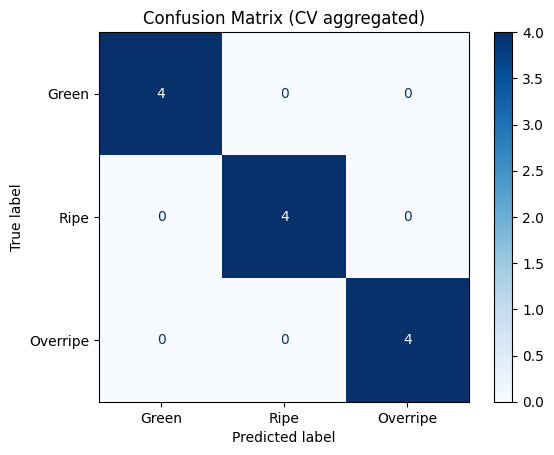

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_3104\4293225542.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top), palette='coolwarm')


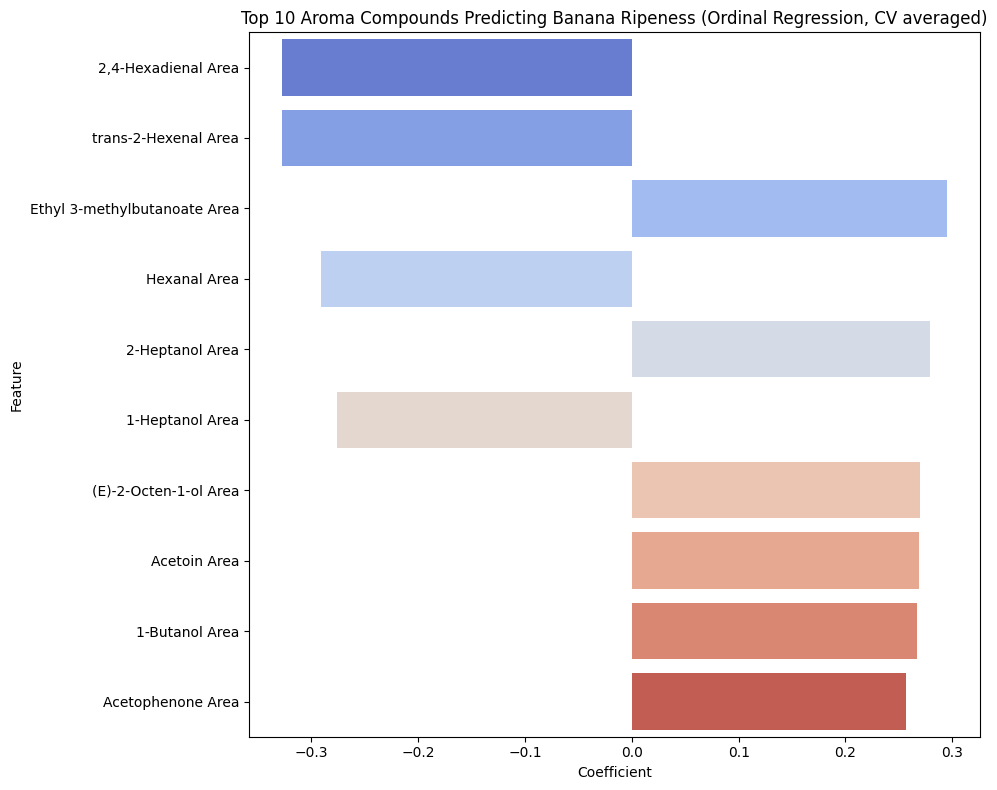

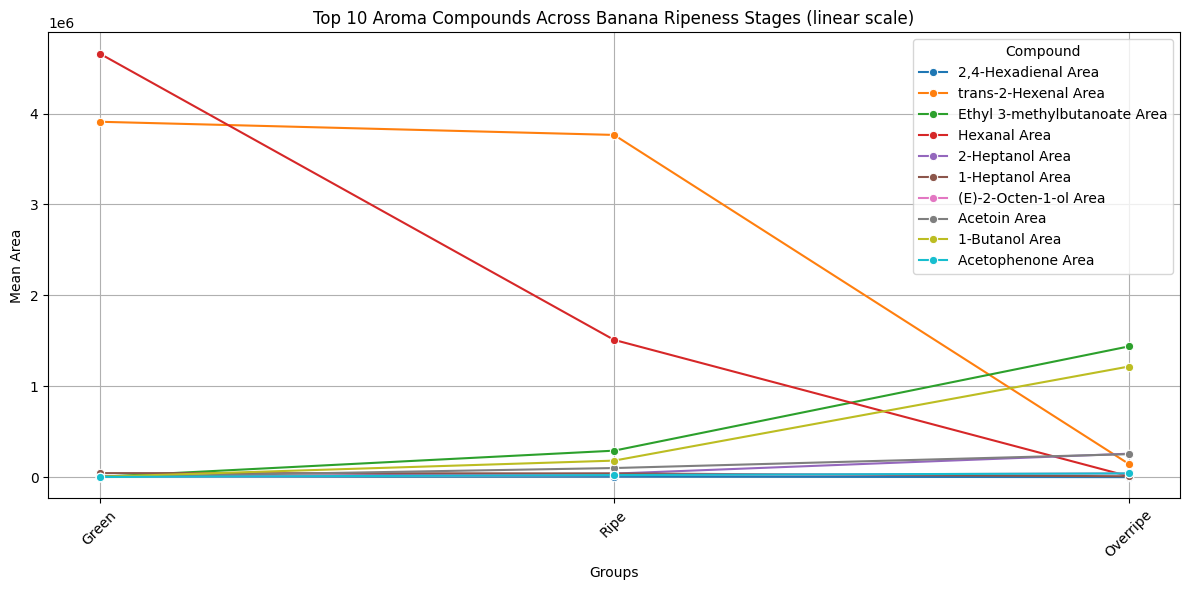

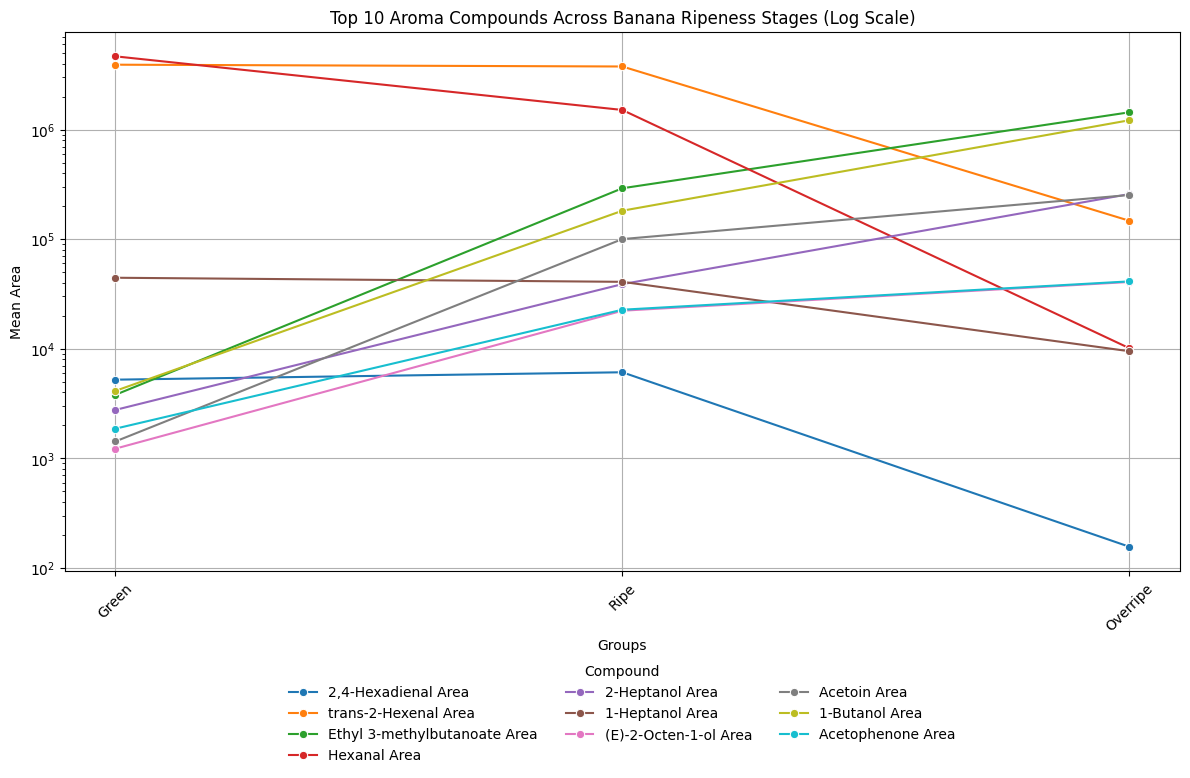

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from mord import LogisticAT  # Ordinal regression model
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# parameter: this can be adjusted to show the number of top values to display in figures
top = 10

# ---------------------------------------------------
# Load dataset
# ---------------------------------------------------
# df = pd.read_csv("badata_imputed_filled.csv")
df = pd.read_csv('badata_imputed.csv')

# Drop the first unnamed column as it's an index
df = df.drop(columns=[df.columns[0]])

# Identify and drop columns with any missing values
missing_cols = df.columns[df.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")
df = df.drop(columns=missing_cols)

# Separate features and target
target = df['Groups']
features = df.drop(columns=['Groups'])

# Encode the target as ordinal: Green < Ripe < Overripe
ordinal_map = {'Green': 0, 'Ripe': 1, 'Overripe': 2}
y = target.map(ordinal_map).values
class_labels = ['Green', 'Ripe', 'Overripe']

# log features
X_log = np.log10(features)

# ---------------------------------------------------
# Cross-validation (leave-one-out per condition)
# ---------------------------------------------------
scaler = MinMaxScaler()
model = LogisticAT()

pipe = Pipeline([
    ("scaler", scaler),
    ("model", model)
])

# Number of folds = min samples per class
n_splits = df['Groups'].value_counts().min()
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

scores = []
bal_scores = []
coef_list = []
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(cv.split(X_log, y)):
    pipe.fit(X_log.iloc[train_idx], y[train_idx])
    
    # predictions
    y_pred = pipe.predict(X_log.iloc[test_idx])
    y_true = y[test_idx]
    
    # store
    all_true.extend(y_true)
    all_pred.extend(y_pred)
    
    # metrics
    acc = pipe.score(X_log.iloc[test_idx], y_true)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    scores.append(acc)
    bal_scores.append(bal_acc)
    
    # coefficients
    coefs = pipe.named_steps['model'].coef_.flatten()
    coef_list.append(coefs)
    
    print(f"Fold {fold+1} accuracy: {acc:.3f} | balanced accuracy: {bal_acc:.3f}")
    print(f"  True: {y_true} | Pred: {y_pred}")

print(f"\nMean CV accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
print(f"Mean balanced accuracy: {np.mean(bal_scores):.3f} ± {np.std(bal_scores):.3f}")

# ---------------------------------------------------
# Confusion matrix (aggregated across folds)
# ---------------------------------------------------
cm = confusion_matrix(all_true, all_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (CV aggregated)")
plt.show()

# ---------------------------------------------------
# Feature importance (averaged coefs)
# ---------------------------------------------------
coef_array = np.vstack(coef_list)
mean_coefs = coef_array.mean(axis=0)

feature_names = features.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': mean_coefs,
    'Abs_Coefficient': np.abs(mean_coefs)
}).sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top), palette='coolwarm')
plt.title(f'Top {top} Aroma Compounds Predicting Banana Ripeness (Ordinal Regression, CV averaged)')
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Group means for plotting across conditions
# ---------------------------------------------------
top_features = coef_df.head(top)['Feature'].values
grouped_means = df.groupby('Groups')[top_features].mean().reset_index()

melted_df = grouped_means.melt(id_vars='Groups', var_name='Compound', value_name='Mean Area')
melted_df['Groups'] = pd.Categorical(melted_df['Groups'], categories=['Green', 'Ripe', 'Overripe'], ordered=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.title(f'Top {top} Aroma Compounds Across Banana Ripeness Stages (linear scale)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.yscale('log')
plt.title(f'Top {top} Aroma Compounds Across Banana Ripeness Stages (Log Scale)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    title="Compound",
    frameon=False
)
plt.tight_layout()
plt.show()
